In [68]:
import pickle
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/Users/rachelkogan/anaconda/envs/py27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
train = pd.read_pickle('train_bow_labels.pkl')
test = pd.read_pickle('test_bow_labels.pkl')

train.head()

,id,title,text_clean,pov
0,619941,Loch Katrine,infobox lake name loch katrin imag loch katrin...,False
1,3884222,Bhadayasa,infobox royalti imag filebhadrayasha coinjpg a...,False
2,4229879,Lee Jones (author),lee jone onlin poker execut author win low lim...,False
3,5320685,School District 54 Bulkley Valley,infobox school district name school district b...,False
4,9146365,Combing,interlac disambiguationinterlaceth comb hairco...,False


In [9]:
#create bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
train_data_features = vectorizer.fit_transform(train['text_clean']).toarray()
feature_matrix = pd.DataFrame(train_data_features, index = train['title'], columns=vectorizer.get_feature_names())

test_data_features = vectorizer.transform(test['text_clean']).toarray()
test_feature_matrix = pd.DataFrame(test_data_features, index = test['title'], columns=vectorizer.get_feature_names())

In [183]:
#create ensemble data frame

ensemble = pd.DataFrame(test[['title', 'pov']]).set_index('title')
ensemble.head()

,pov
title,
Meitei Christians,True
Musical expression,True
READ 180,True
The Ambulance,False
Sifo Company,False


In [185]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=.4) 

logit = logit.fit(feature_matrix, train['pov'])
ensemble['logit']=pd.DataFrame(logit.predict_proba(test_feature_matrix), index=test['title'])[1]
ensemble.head()

,pov,logit
title,,
Meitei Christians,True,0.995124
Musical expression,True,0.944641
READ 180,True,0.999841
The Ambulance,False,0.040362
Sifo Company,False,0.049162


In [186]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100, criterion='entropy') 
forest.fit(feature_matrix, train['pov'])
ensemble['forest'] = pd.DataFrame(forest.predict_proba(test_feature_matrix), index=test['title'])[1]
ensemble.head()

,pov,logit,forest
title,,,
Meitei Christians,True,0.995124,0.90
Musical expression,True,0.944641,0.32
READ 180,True,0.999841,0.92
The Ambulance,False,0.040362,0.35
Sifo Company,False,0.049162,0.30


In [41]:
from sklearn.svm import SVC
svc = SVC(C=100, kernel='linear', probability=True) 
svc = svc.fit(feature_matrix, train['pov'])

In [249]:
ensemble['svc'] = pd.DataFrame(svc.predict(test_feature_matrix), index=test['title'])
ensemble.head()

,pov,logit,forest,svc,mnb,xgboost,logit_p,forest_p,mnb_p,svc_p,xgboost_p,mean_by_p,mean_logit_forest_p,mean_logit_mnb_p,mean_logit_forest_xgb_p,mean_logit_xgb_p,mean_logit_xgb_mnb_p,mean_logit_xgb_mnb_svc_p
title,,,,,,,,,,,,,,,,,,
Meitei Christians,1,0.995124,0.90,True,1.000000e+00,0.992602,1.0,1.0,1.0,0.0,1.0,0.868660,0.947562,0.997562,0.993863,0.993863,0.995909,0.860825
Musical expression,1,0.944641,0.32,True,1.000000e+00,0.146504,1.0,0.0,1.0,0.0,0.0,0.559182,0.632321,0.972321,0.545573,0.545573,0.697049,0.618977
READ 180,1,0.999841,0.92,True,1.000000e+00,0.997531,1.0,1.0,1.0,1.0,1.0,0.904567,0.959920,0.999920,0.998686,0.998686,0.999124,0.900709
The Ambulance,0,0.040362,0.35,False,4.585424e-22,0.060047,0.0,0.0,0.0,0.0,0.0,0.160353,0.195181,0.020181,0.050204,0.050204,0.033470,0.112941
Sifo Company,0,0.049162,0.30,False,7.758952e-07,0.115786,0.0,0.0,0.0,0.0,0.0,0.164247,0.174581,0.024581,0.082474,0.082474,0.054983,0.130309


In [43]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(train_data_features, train['pov'])

In [188]:
ensemble['mnb'] = pd.DataFrame(mnb.predict_proba(test_feature_matrix), index=test['title'])[1]
ensemble.head()

,pov,logit,forest,svc,mnb
title,,,,,
Meitei Christians,True,0.995124,0.90,0.455575,1.000000e+00
Musical expression,True,0.944641,0.32,0.384762,1.000000e+00
READ 180,True,0.999841,0.92,0.605464,1.000000e+00
The Ambulance,False,0.040362,0.35,0.351355,4.585424e-22
Sifo Company,False,0.049162,0.30,0.356289,7.758952e-07


In [190]:
ensemble['pov'] = ensemble['pov'].map(lambda x: int(x))
#ensemble.reset_index(inplace=True)
ensemble.head()


,pov,logit,forest,svc,mnb,xgboost
title,,,,,,
Meitei Christians,1,0.995124,0.90,0.455575,1.000000e+00,0.992602
Musical expression,1,0.944641,0.32,0.384762,1.000000e+00,0.146504
READ 180,1,0.999841,0.92,0.605464,1.000000e+00,0.997531
The Ambulance,0,0.040362,0.35,0.351355,4.585424e-22,0.060047
Sifo Company,0,0.049162,0.30,0.356289,7.758952e-07,0.115786


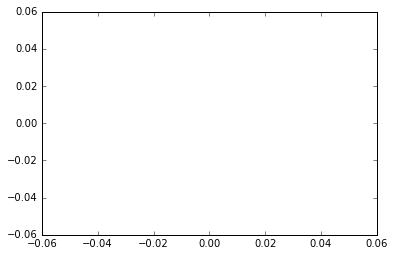

In [66]:
Fig, ax = plt.subplots()
ax.plot(x=ensemble['title'], y=ensemble['pov'], color='Blue', linestyle = 'None', label= 'True Label')

#ax = ensemble.iloc[:50].plot(x='title', y='pov', color='DarkBlue', label='True Label', );
plt.show()
#df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);

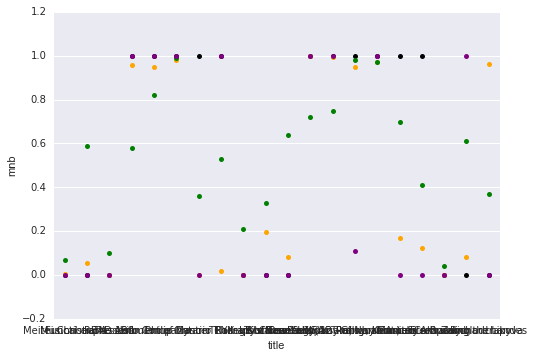

In [88]:
sns.stripplot(x="title", y="pov", data=ensemble.iloc[:20], color='black', label='True Label')
sns.stripplot(x="title", y="logit", data=ensemble.iloc[:20], color='orange', label='logit')
sns.stripplot(x="title", y="forest", data=ensemble.iloc[:20], color='green', label='forest')
sns.stripplot(x="title", y="mnb", data=ensemble.iloc[:20], color='purple', label='naive bayes')
#sns.stripplot(x="title", y="svcp", data=ensemble.iloc[:20], color='red', label='support vector machine')

#plt.legend()
plt.show()

In [142]:
logit_misclassified = ensemble[ensemble['pov']!=np.round(ensemble['logit'])]
logit_misclassified.head()

,title,pov,logit,forest,mnb,svc,logit_p,forest_p,mnb_p,svc_p,mean_by_p,mean_logit_forest_p,mean_logit_mnb_p
0,Meitei Christians,1,0.004876,0.07,2.047682e-43,0.544425,0.0,0.0,0.0,1.0,0.154825,0.037438,0.002438
1,Musical expression,1,0.055359,0.59,7.765109e-14,0.615238,0.0,1.0,0.0,1.0,0.315149,0.322679,0.027679
2,READ 180,1,0.000159,0.10,8.635454e-69,0.394536,0.0,0.0,0.0,0.0,0.123674,0.050080,0.000080
3,The Ambulance,0,0.959638,0.58,1.000000e+00,0.648645,1.0,1.0,1.0,1.0,0.797071,0.769819,0.979819
4,Sifo Company,0,0.950838,0.82,9.999992e-01,0.643711,1.0,1.0,1.0,1.0,0.853637,0.885419,0.975419


In [104]:
ensemble.drop('svcp', axis=1, inplace=True)
ensemble.corr()

,pov,logit,forest,mnb,svc
pov,1.000000,0.764913,0.808483,0.524455,0.515737
logit,0.764913,1.000000,0.839441,0.603277,0.688552
forest,0.808483,0.839441,1.000000,0.627960,0.585851
mnb,0.524455,0.603277,0.627960,1.000000,0.477334
svc,0.515737,0.688552,0.585851,0.477334,1.000000


In [108]:
logit_misclassified.corr()

,pov,logit,forest,mnb,svc
pov,1.000000,-0.918039,-0.040849,-0.102278,-0.588672
logit,-0.918039,1.000000,0.165319,0.205900,0.680982
forest,-0.040849,0.165319,1.000000,0.330519,0.208250
mnb,-0.102278,0.205900,0.330519,1.000000,0.124092
svc,-0.588672,0.680982,0.208250,0.124092,1.000000


In [110]:
forest_misclassified = ensemble[ensemble['pov']!=np.round(ensemble['forest'])]
forest_misclassified.head()

,title,pov,logit,forest,mnb,svc
1,Musical expression,0,0.055359,0.59,7.765109e-14,0.615238
6,Functional Assessment of Cancer Therapy - Gene...,1,0.000230,0.36,8.420582e-84,0.593686
10,TV Channel 16/12,0,0.083336,0.64,2.529616e-21,0.629694
16,Mustafa Akhwand,1,0.123860,0.41,2.789547e-27,0.582938
18,Elena Zamolodchikova,0,0.082635,0.61,1.000000e+00,0.635210


In [111]:
forest_misclassified.corr()

,pov,logit,forest,mnb,svc
pov,1.000000,-0.082338,-0.803986,-0.164992,-0.135184
logit,-0.082338,1.000000,0.248246,0.324507,0.672422
forest,-0.803986,0.248246,1.000000,0.367904,0.263069
mnb,-0.164992,0.324507,0.367904,1.000000,0.218705
svc,-0.135184,0.672422,0.263069,0.218705,1.000000


In [151]:
logit_misclassified[(logit_misclassified['pov']==1) & (logit_misclassified['svc']>.5)][['title', 'logit']].head()

,title,logit
0,Meitei Christians,0.004876
1,Musical expression,0.055359
9,Rama Kishore Singh,0.195443
10,TV Channel 16/12,0.083336
18,Elena Zamolodchikova,0.082635


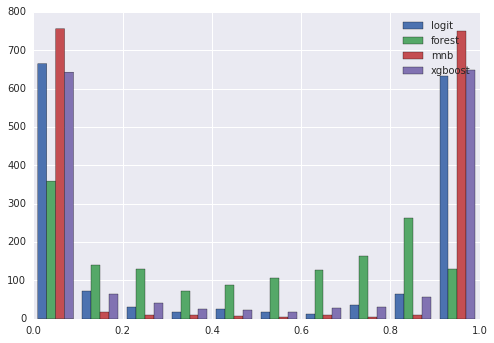

In [256]:
plt.hist([ensemble['logit'], ensemble['forest'], ensemble['mnb'], ensemble['xgboost']], 
        label = ['logit', 'forest', 'mnb', 'xgboost'])
plt.legend()
plt.show()




In [126]:
import xgboost as xgb
dtrain = xgb.DMatrix(feature_matrix, train['pov'])
d_val = xgb.DMatrix(test_feature_matrix, test['pov'])

# hyperparameters
xgb_params = {
    'eta': 0.35,
    'max_depth': 4,
    'subsample': .8,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'silent': 1
}

sub_model = xgb.train(xgb_params, dtrain, num_boost_round=2000, evals=[[dtrain, 'train'], (d_val, 'val')],
                      early_stopping_rounds=50, verbose_eval=20)

[0]	train-error:0.250343	val-error:0.307351
Multiple eval metrics have been passed: 'val-error' will be used for early stopping.

Will train until val-error hasn't improved in 50 rounds.
[20]	train-error:0.147328	val-error:0.211027
[40]	train-error:0.095706	val-error:0.186312
[60]	train-error:0.067839	val-error:0.159696
[80]	train-error:0.049338	val-error:0.149556
[100]	train-error:0.034491	val-error:0.143853
[120]	train-error:0.023984	val-error:0.13308
[140]	train-error:0.01873	val-error:0.132446
[160]	train-error:0.014619	val-error:0.126109
[180]	train-error:0.011421	val-error:0.119772
[200]	train-error:0.009593	val-error:0.119138
[220]	train-error:0.007081	val-error:0.116603
[240]	train-error:0.006167	val-error:0.115336
[260]	train-error:0.005482	val-error:0.114702
[280]	train-error:0.003426	val-error:0.112167
[300]	train-error:0.002969	val-error:0.112801
[320]	train-error:0.002056	val-error:0.1109
[340]	train-error:0.000685	val-error:0.108999
[360]	train-error:0.000685	val-error:0.

In [129]:
xgb_params = {
    'eta': 0.35,
    'max_depth': 5,
    'subsample': .8,
    'colsample_bytree': 0.5,
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'silent': 1
}

sub_model = xgb.train(xgb_params, dtrain, num_boost_round=2000, evals=[[dtrain, 'train'], (d_val, 'val')],
                      early_stopping_rounds=50, verbose_eval=20)

[0]	train-error:0.238922	val-error:0.298479
Multiple eval metrics have been passed: 'val-error' will be used for early stopping.

Will train until val-error hasn't improved in 50 rounds.
[20]	train-error:0.103472	val-error:0.183777
[40]	train-error:0.060987	val-error:0.1673
[60]	train-error:0.038831	val-error:0.145754
[80]	train-error:0.029466	val-error:0.140684
[100]	train-error:0.017588	val-error:0.129278
[120]	train-error:0.012334	val-error:0.123574
[140]	train-error:0.008908	val-error:0.117871
[160]	train-error:0.006624	val-error:0.116603
[180]	train-error:0.004797	val-error:0.113435
[200]	train-error:0.003655	val-error:0.114702
[220]	train-error:0.002513	val-error:0.112801
[240]	train-error:0.001827	val-error:0.1109
[260]	train-error:0.00137	val-error:0.107731
[280]	train-error:0.000685	val-error:0.1109
[300]	train-error:0.000457	val-error:0.107731
[320]	train-error:0.000457	val-error:0.108999
[340]	train-error:0.000457	val-error:0.109632
Stopping. Best iteration:
[305]	train-erro

In [189]:
ensemble['xgboost']=sub_model.predict(d_val)
ensemble.head()

,pov,logit,forest,svc,mnb,xgboost
title,,,,,,
Meitei Christians,True,0.995124,0.90,0.455575,1.000000e+00,0.992602
Musical expression,True,0.944641,0.32,0.384762,1.000000e+00,0.146504
READ 180,True,0.999841,0.92,0.605464,1.000000e+00,0.997531
The Ambulance,False,0.040362,0.35,0.351355,4.585424e-22,0.060047
Sifo Company,False,0.049162,0.30,0.356289,7.758952e-07,0.115786


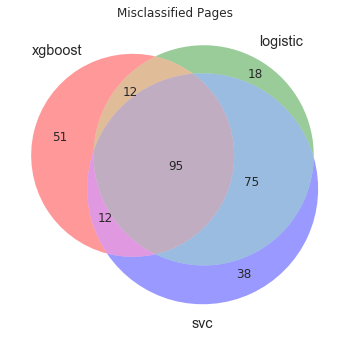

In [251]:
from matplotlib_venn import venn3, venn3_circles
set1 = set(ensemble[ensemble['pov']!=np.round(ensemble['xgboost'])].index)
set2 = set(ensemble[ensemble['pov']!=np.round(ensemble['logit'])].index)
set3 = set(ensemble[ensemble['pov']!=np.round(ensemble['svc'])].index)

venn3([set1, set2, set3], ('xgboost', 'logistic', 'svc'))
plt.title("Misclassified Pages")
plt.show()

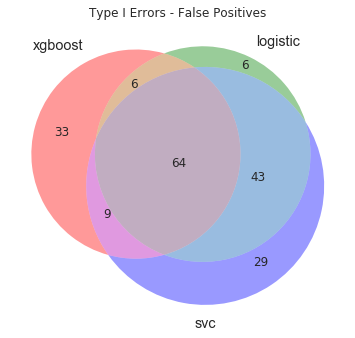

In [252]:
from matplotlib_venn import venn3, venn3_circles
set1 = set(ensemble[(ensemble['pov']!=np.round(ensemble['xgboost'])) & (ensemble['pov']==0)].index)
set2 = set(ensemble[(ensemble['pov']!=np.round(ensemble['logit'])) & (ensemble['pov']==0)].index)
set3 = set(ensemble[(ensemble['pov']!=np.round(ensemble['svc'])) & (ensemble['pov']==0)].index)

venn3([set1, set2, set3], ('xgboost', 'logistic', 'svc'))
plt.title("Type I Errors - False Positives")
plt.show()

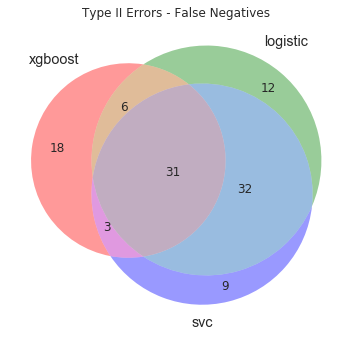

In [253]:
from matplotlib_venn import venn3, venn3_circles
set1 = set(ensemble[(ensemble['pov']!=np.round(ensemble['xgboost'])) & (ensemble['pov']==1)].index)
set2 = set(ensemble[(ensemble['pov']!=np.round(ensemble['logit'])) & (ensemble['pov']==1)].index)
set3 = set(ensemble[(ensemble['pov']!=np.round(ensemble['svc'])) & (ensemble['pov']==1)].index)

venn3([set1, set2, set3], ('xgboost', 'logistic', 'svc'))
plt.title("Type II Errors - False Negatives")
plt.show()

In [255]:
ensemble['logit_p']=np.round(ensemble['logit'])
ensemble['forest_p']=np.round(ensemble['forest'])
ensemble['mnb_p']=np.round(ensemble['mnb'])
ensemble['svc_p']=np.round(ensemble['svc'])
ensemble['xgboost_p']=np.round(ensemble['xgboost'])
ensemble.head()

models = ['logit', 'forest', 'mnb', 'svc', 'xgboost']
for model in models:
    print model, sum(ensemble['pov']==ensemble[model+"_p"])
    
ensemble['mean_by_p']=ensemble[models].mean(axis=1)


print 'mean_by_p', sum(ensemble['pov']==np.round(ensemble['mean_by_p']))

ensemble['mean_logit_forest_p']=ensemble[['logit', 'forest']].mean(axis=1)

print 'mean_logit_forest_p', sum(ensemble['pov']==np.round(ensemble['mean_logit_forest_p']))

ensemble['mean_logit_xgb_p']=ensemble[['logit', 'xgboost']].mean(axis=1)

print 'mean_logit_xgb_p', sum(ensemble['pov']==np.round(ensemble['mean_logit_xgb_p']))

ensemble['mean_logit_xgb_mnb_p']=ensemble[['logit', 'xgboost', 'mnb']].mean(axis=1)

print 'mean_logit_xgb_mnb_p', sum(ensemble['pov']==np.round(ensemble['mean_logit_xgb_mnb_p']))

ensemble['mean_logit_xgb_mnb_svc_p']=ensemble[['logit', 'xgboost', 'mnb', 'svc']].mean(axis=1)

print 'mean_logit_xgb_mnb_svc_p', sum(ensemble['pov']==np.round(ensemble['mean_logit_xgb_mnb_svc_p']))

print
print 'mean_logit_xgb_mnb_p', sum((ensemble['pov']==np.round(ensemble['mean_logit_xgb_mnb_p'])) & ensemble['pov']==1)
print 'mean_xgb_p', sum((ensemble['pov']==np.round(ensemble['xgboost_p'])) & ensemble['pov']==1)

logit 1378
forest 1387
mnb 1194
svc 1358
xgboost 1408
mean_by_p 1400
mean_logit_forest_p 1395
mean_logit_xgb_p 1406
mean_logit_xgb_mnb_p 1399
mean_logit_xgb_mnb_svc_p 1397

mean_logit_xgb_mnb_p 670
mean_xgb_p 669


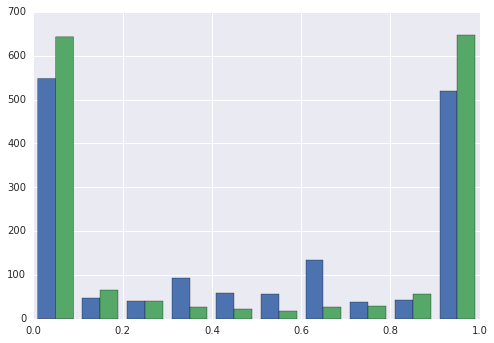

In [223]:
plt.hist([ensemble['mean_logit_xgb_mnb_p'], ensemble['xgboost']], )
#plt.legend()
plt.show()


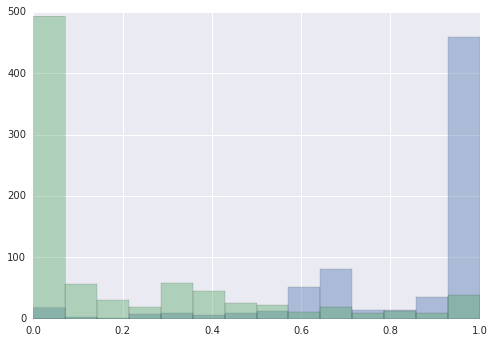

In [240]:
ensemble_1 = ensemble[ensemble['pov']==1]
ensemble_0 = ensemble[ensemble['pov']==0]

sns.distplot([ensemble_1['mean_logit_xgb_mnb_p']], kde=False)
sns.distplot([ensemble_0['mean_logit_xgb_mnb_p']], kde=False)

#plt.legend()
plt.show()